In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
from time import time

from data_loader import *
from models import CNNLSTM

In [2]:
root_path = './SWaT'
args = None
win_size = 64
step = 8
train_data = SWATSegLoader(None, root_path, win_size, step, 'train')
# test_data = SWATSegLoader(None, root_path, win_size, step, 'test')
print('Train data:', len(train_data))
print('Train data shape:', train_data[0][0].shape)


SWaT train data shape: (495000, 51)
Train data: 61867
Train data shape: (64, 51)


In [ ]:

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0):
        super(LSTMAutoencoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 编码器
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

        # 解码器
        self.liner = nn.Linear(hidden_size, input_size)
        self.decoder = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

    def forward(self, x):
        hidden_cell = (torch.randn(self.num_layers, x.size(0), self.hidden_size),
                          torch.randn(self.num_layers, x.size(0), self.hidden_size))
        _, hidden_cell = self.encoder(x, hidden_cell)
        x4decoder = x[:, -1, :].unsqueeze(1)    # 取输入序列最后一个作为解码器的输入
        # print(x4decoder.shape)
        output = torch.zeros(x.size())
        for i in range(x.size(1)-1, -1, -1):   # 逆序解码
            x4decoder, hidden_cell = self.decoder(x4decoder, hidden_cell)
            x4decoder = self.liner(x4decoder)
            output[:,i,:] = x4decoder.squeeze(1)

        return output

# 初始化模型
model = LSTMAutoencoder(input_size=51, hidden_size=32, num_layers=1, dropout=0.1)
# 验证
win_size = 16
x = torch.randn(64, win_size, 51)
model(x).shape

d:\LenovoSoftstore\Install\miniconda3\envs\dl-lab\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


torch.Size([64, 16, 51])

In [18]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 编码器
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

        # 预测器
        self.liner = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        # hidden: [num_layers, batch_size, hidden_size]
        output = self.liner(hidden[-1])
        return output
model = LSTMPredictor(input_size=51, hidden_size=64, num_layers=4)
# 验证
x = torch.randn(64, win_size, 51)
model(x).shape


torch.Size([64, 51])

In [ ]:

# 使用示例
model = CNNLSTM(input_dim=51, hidden_dim=64, output_dim=51, lstm_layers=1)
# 验证
x = torch.randn(64, win_size, 51)
model(x).shape

torch.Size([64, 51])

In [14]:
# 设置超参数
learning_rate = 0.01
num_epochs = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
data_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# 训练循环，显示进度条
losses = []
model.train()
for epoch in tqdm(range(num_epochs)):
    for i, (x, x_1) in enumerate(data_loader):
        optimizer.zero_grad()
        y = model(x)
        # loss = criterion(y, x)
        loss = criterion(y, x_1)  # 下一步的数据作为预测目标
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if i % 500 == 0:
            print(f'Epoch {epoch}, batch {i}, loss: {loss.item()}')


print(np.mean(losses))


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, batch 0, loss: 0.4639279842376709
Epoch 0, batch 500, loss: 0.012934081256389618
Epoch 0, batch 1000, loss: 0.01767830364406109
Epoch 0, batch 1500, loss: 0.05540043115615845


 10%|█         | 1/10 [00:12<01:54, 12.67s/it]

Epoch 1, batch 0, loss: 0.00484632421284914
Epoch 1, batch 500, loss: 0.02298603765666485
Epoch 1, batch 1000, loss: 0.11522527784109116
Epoch 1, batch 1500, loss: 0.008933077566325665


 20%|██        | 2/10 [00:25<01:40, 12.58s/it]

Epoch 2, batch 0, loss: 0.0026303681079298258
Epoch 2, batch 500, loss: 0.054441191256046295
Epoch 2, batch 1000, loss: 0.006727986503392458
Epoch 2, batch 1500, loss: 0.018681233748793602


 30%|███       | 3/10 [00:37<01:28, 12.66s/it]

Epoch 3, batch 0, loss: 0.0034425079356878996
Epoch 3, batch 500, loss: 0.015389750711619854
Epoch 3, batch 1000, loss: 0.03470517322421074
Epoch 3, batch 1500, loss: 0.0031952057033777237


 40%|████      | 4/10 [00:50<01:16, 12.76s/it]

Epoch 4, batch 0, loss: 0.0042004818096756935
Epoch 4, batch 500, loss: 0.06380918622016907
Epoch 4, batch 1000, loss: 0.007050426676869392
Epoch 4, batch 1500, loss: 0.015245894901454449


 50%|█████     | 5/10 [01:04<01:05, 13.09s/it]

Epoch 5, batch 0, loss: 0.008034748025238514
Epoch 5, batch 500, loss: 0.005945969372987747
Epoch 5, batch 1000, loss: 0.010319732129573822
Epoch 5, batch 1500, loss: 0.004307293798774481


 60%|██████    | 6/10 [01:18<00:53, 13.42s/it]

Epoch 6, batch 0, loss: 0.0022319890558719635
Epoch 6, batch 500, loss: 0.0028930283151566982
Epoch 6, batch 1000, loss: 0.010865433141589165
Epoch 6, batch 1500, loss: 0.05601438507437706


 70%|███████   | 7/10 [01:31<00:39, 13.20s/it]

Epoch 7, batch 0, loss: 0.004982169717550278
Epoch 7, batch 500, loss: 0.006965411826968193
Epoch 7, batch 1000, loss: 0.0028701971750706434
Epoch 7, batch 1500, loss: 0.02628478966653347


 80%|████████  | 8/10 [01:44<00:26, 13.08s/it]

Epoch 8, batch 0, loss: 0.09429382532835007
Epoch 8, batch 500, loss: 0.005727539304643869
Epoch 8, batch 1000, loss: 0.0031975239980965853
Epoch 8, batch 1500, loss: 0.024050265550613403


 90%|█████████ | 9/10 [01:57<00:13, 13.21s/it]

Epoch 9, batch 0, loss: 0.015603098087012768
Epoch 9, batch 500, loss: 0.0029471584130078554
Epoch 9, batch 1000, loss: 0.12652362883090973
Epoch 9, batch 1500, loss: 0.10206233710050583


100%|██████████| 10/10 [02:11<00:00, 13.10s/it]

0.027243971335602322


In [15]:
# 加载模型

# model1 = LSTMPredictor(input_size=51, hidden_size=32, num_layers=1, dropout=0.1)
# model1 = CNNLSTM(input_dim=51, hidden_dim=64, output_dim=51)
# model1.load_state_dict(torch.load('./checkpoints/lstm_autoencoder-1742472367.4708393.pth'))
model1 = model
model1.eval()
# test_data = pd.read_csv(os.path.join(root_path, 'swat2.csv'))
root_path = './SWaT'
args = None
test_data = SWATSegLoader(None, root_path, win_size, 1, 'test')  # 测试集窗口步数为1
print('Test data:', len(test_data))
y_true = test_data.test_labels
test_data_loader = DataLoader(test_data, batch_size=64, shuffle=False)

SWaT test data shape: (449919, 51)
Test data: 449855


In [8]:
print(y_true.shape)

(449919, 1)


In [35]:
criterion = nn.MSELoss(reduction='none')
x = torch.randn(64, 51) # batch_size, seq_len, input_dim
y = torch.randn(64, 51)
# loss 希望是一个长度为 batch_size 的列表
loss = criterion(x, y).mean(dim=1)
print(loss.shape)


torch.Size([64])


In [16]:
test_losses = []
criterion = nn.MSELoss(reduction='none')

with torch.no_grad():
    for x, x_1 in tqdm(test_data_loader):
        y = model1(x)
        # loss = criterion(y[:,-1,:], x[:,-1,:]).mean(dim=1)
        loss = criterion(y, x_1).mean(dim=1)
        test_losses += loss.tolist()
            
print(test_losses.__len__())



  0%|          | 0/7029 [00:00<?, ?it/s]

d:\LenovoSoftstore\Install\miniconda3\envs\dl-lab\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 51])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 7014/7029 [00:23<00:00, 307.37it/s]d:\LenovoSoftstore\Install\miniconda3\envs\dl-lab\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([63, 1])) that is different to the input size (torch.Size([63, 51])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 7029/7029 [00:23<00:00, 299.98it/s]

449855


In [17]:
for i in [85, 90, 95, 99]:
    threshold = np.percentile(test_losses, i)
    y_pred = (test_losses > threshold).astype(int)
    y_pred = np.concatenate([np.zeros(win_size), y_pred])
    print(f'Anomaly detected: {i}%')
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Attack']))

Anomaly detected: 85%
[[373829  21469]
 [  8611  46010]]
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.96    395298
      Attack       0.68      0.84      0.75     54621

    accuracy                           0.93    449919
   macro avg       0.83      0.89      0.86    449919
weighted avg       0.94      0.93      0.94    449919

Anomaly detected: 90%
[[389253   6045]
 [ 15680  38941]]
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97    395298
      Attack       0.87      0.71      0.78     54621

    accuracy                           0.95    449919
   macro avg       0.91      0.85      0.88    449919
weighted avg       0.95      0.95      0.95    449919

Anomaly detected: 95%
[[395192    106]
 [ 32234  22387]]
              precision    recall  f1-score   support

      Normal       0.92      1.00      0.96    395298
      Attack       1.00      0.41      0.58     54621

    accurac

In [15]:
# 阈值
threshold = np.percentile(test_losses, 88)  # 取95%分位数作为阈值
# 预测
anomalies = np.array(test_losses) > threshold
print('Threshold:', threshold)
print(anomalies[:10])
print(y_true[:10])

anomalies = np.concatenate([np.zeros(win_size), anomalies])   # 补齐前win_size个为0
print(anomalies.shape)

Threshold: 1.0284079313278198
[False False False False False False False False False False]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
(449919,)


In [20]:
print(y_true.shape, anomalies.shape)
y_pred = anomalies
print("Confusion Matrix:\n"  ,confusion_matrix(y_true, y_pred))

print("Classification Report:\n", classification_report(y_true, y_pred))

(449919, 1) (449919,)
Confusion Matrix:
 [[390244   5054]
 [ 14684  39937]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.98    395298
         1.0       0.89      0.73      0.80     54621

    accuracy                           0.96    449919
   macro avg       0.93      0.86      0.89    449919
weighted avg       0.95      0.96      0.95    449919



In [16]:
# 记录y_true==1的位置
y_true_1 = np.where(y_true==1)[0]
print(y_true_1)

[  1754   1755   1756 ... 445188 445189 445190]


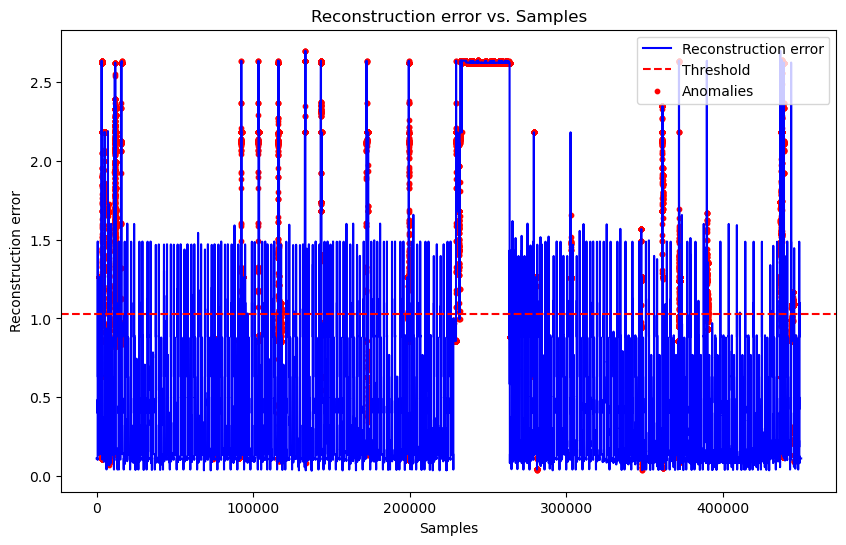

In [17]:
# 可视化重构误差
plt.figure(figsize=(10, 6))
plt.plot(test_losses, 'b', label='Reconstruction error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
# 标出异常点
plt.scatter(y_true_1, np.array(test_losses)[y_true_1], color='r', label='Anomalies', s=10)
plt.xlabel('Samples')
plt.ylabel('Reconstruction error')
plt.title('Reconstruction error vs. Samples')
plt.legend()
plt.show()

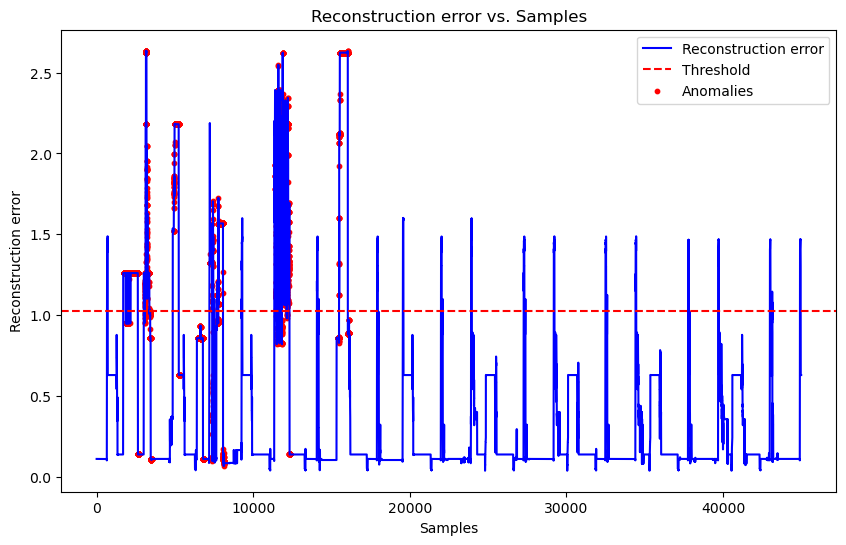

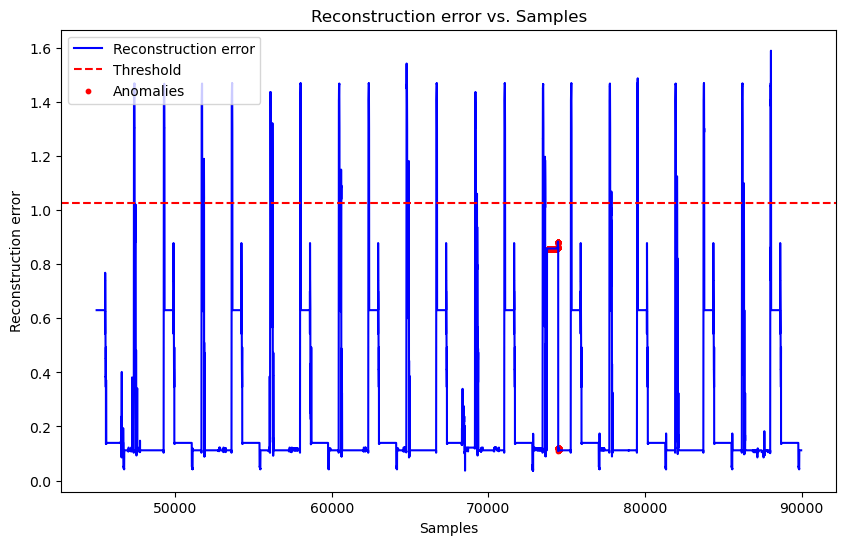

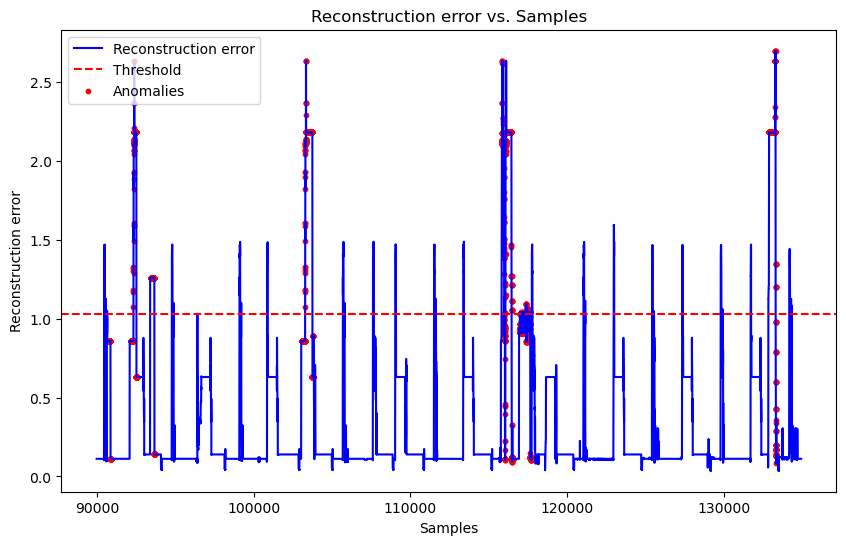

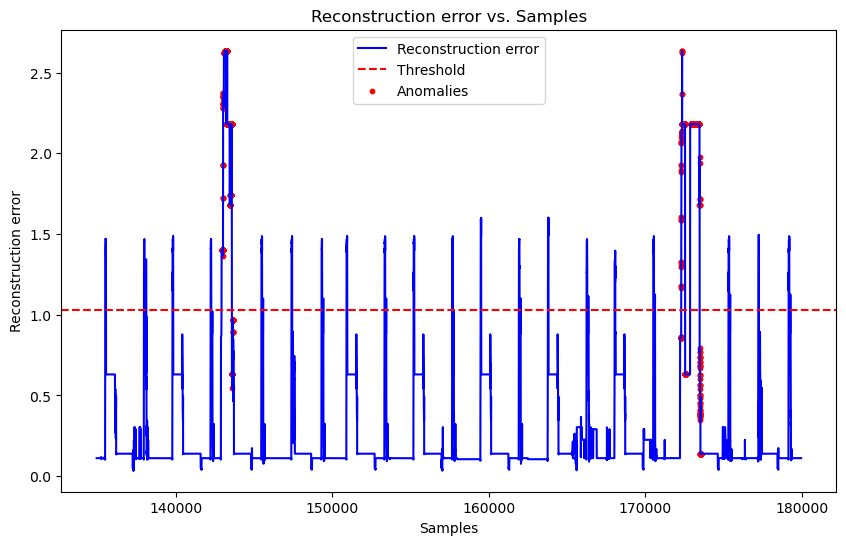

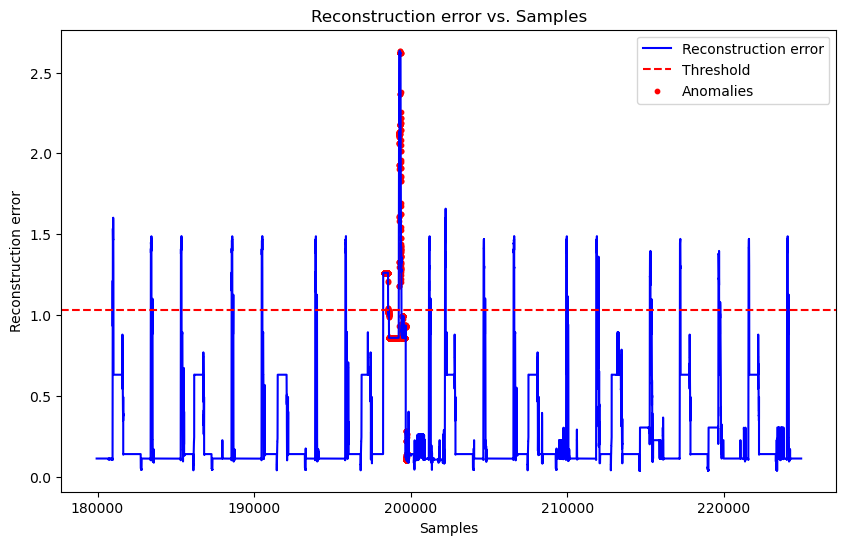

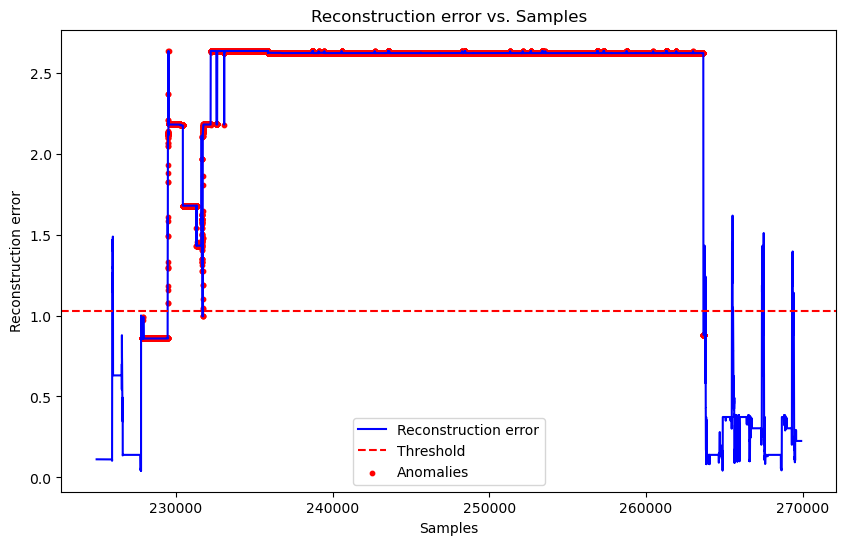

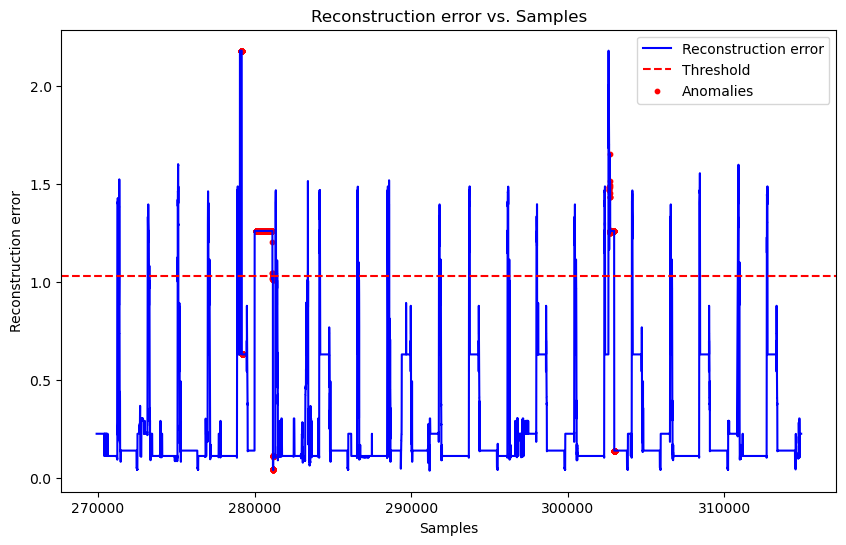

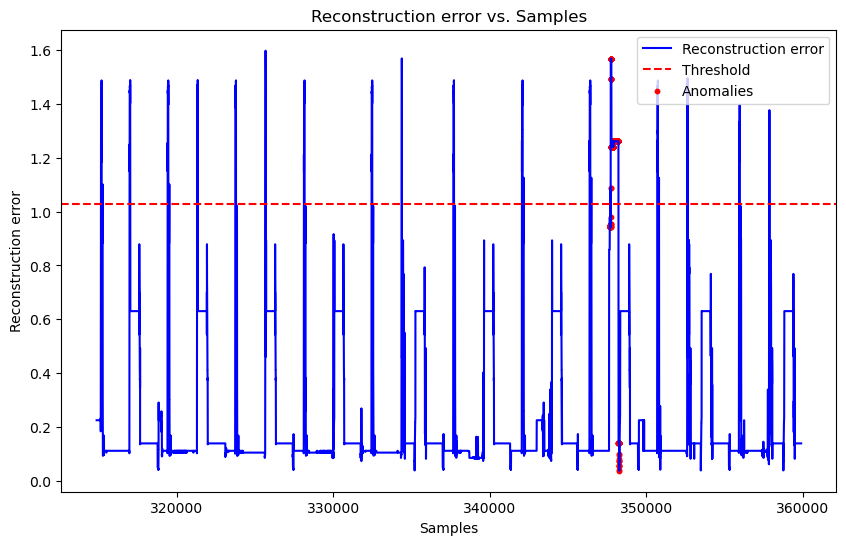

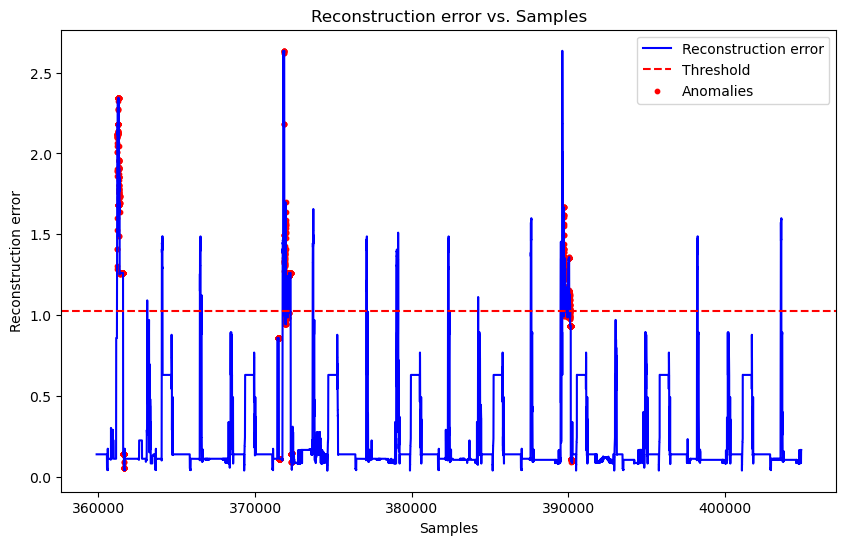

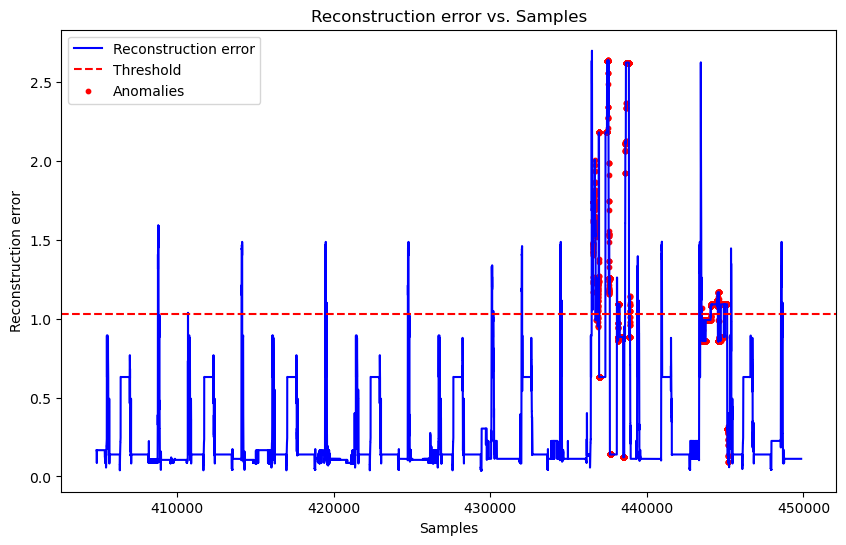

In [19]:


# 可视化重构误差，数据太多，划分n份分别展示
n = 10
for i in range(n):
    plt.figure(figsize=(10, 6))
    # 重构误差，每份展示1/n
    plt.plot(np.arange(i*test_losses.__len__()//n, (i+1)*test_losses.__len__()//n), 
             np.array(test_losses)[i*test_losses.__len__()//n:(i+1)*test_losses.__len__()//n], 'b', label='Reconstruction error')
    # 阈值
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    # 标出异常点
    plt.scatter(y_true_1[(y_true_1>=i*test_losses.__len__()//n) & (y_true_1<(i+1)*test_losses.__len__()//n)], 
                np.array(test_losses)[y_true_1[(y_true_1>=i*test_losses.__len__()//n) & (y_true_1<(i+1)*test_losses.__len__()//n)]], 
                color='r', label='Anomalies', s=10)
    # x轴取值范围

    plt.xlabel('Samples')
    plt.ylabel('Reconstruction error')
    plt.title('Reconstruction error vs. Samples')
    plt.legend()
    plt.show()